In [45]:
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import tensorflow as tf


In [46]:
# -------------------------------
# Download stock data
# -------------------------------
now = datetime.now()
tickers = 'AAPL'
start = datetime(now.year - 10, now.month, now.day)

df = yf.download(tickers=tickers, start=start, end=now)
df = df.reset_index()

C:\Users\kinshuk\AppData\Local\Temp\ipykernel_3500\2938708255.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=tickers, start=start, end=now)
[*********************100%***********************]  1 of 1 completed


In [47]:

# plt.figure(figsize=(10, 5))
# plt.plot(df['Close'], label='AAPL Closing Price')
# plt.title('AAPL Closing Price - Last 10 Years')
# plt.xlabel('Date')
# plt.ylabel('Price (USD)')
# plt.legend()
# plt.grid(True)
# plt.show()

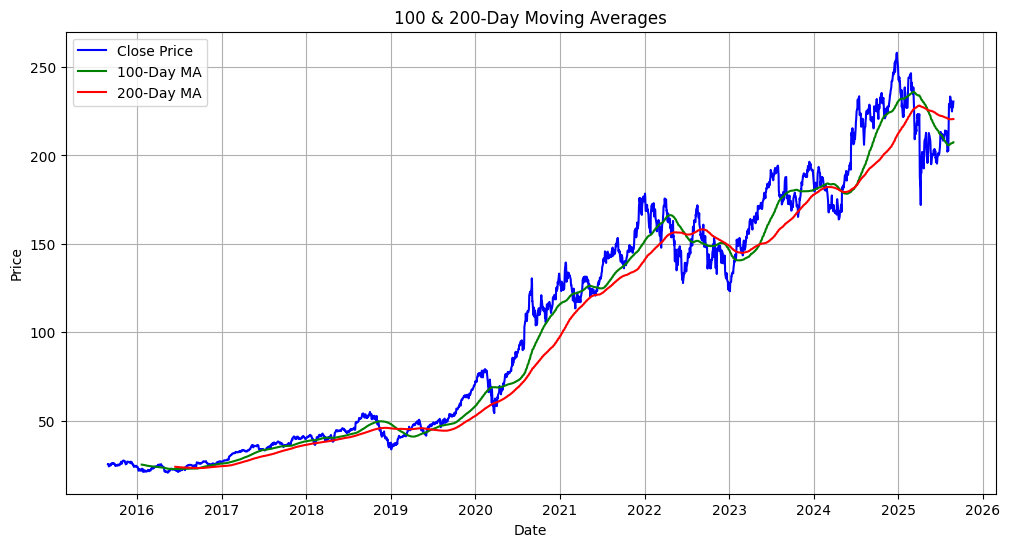

In [48]:
# -------------------------------
# Moving Averages
# -------------------------------
df['MA_100'] = df['Close'].rolling(100).mean()
df['MA_200'] = df['Close'].rolling(200).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['MA_100'], label='100-Day MA', color='g')
plt.plot(df['Date'], df['MA_200'], label='200-Day MA', color='red')
plt.title('100 & 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

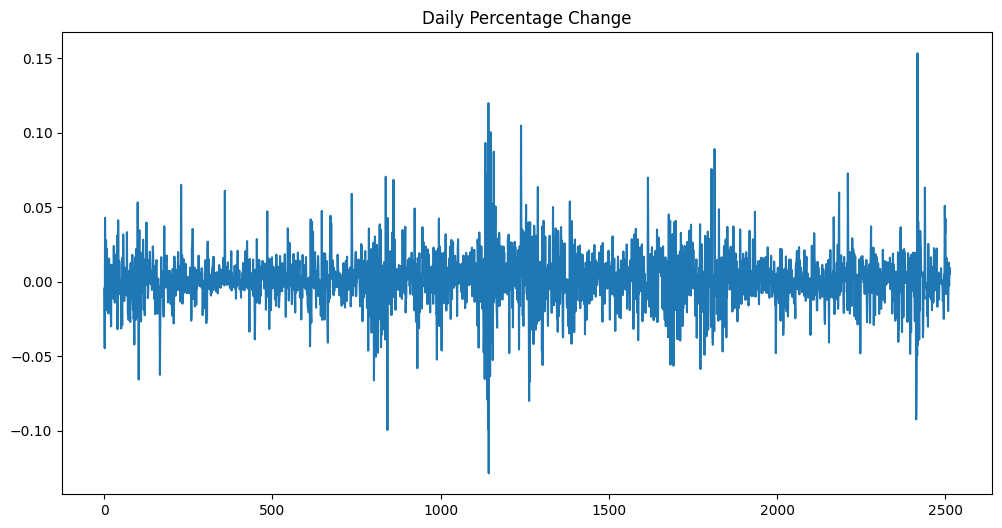

In [49]:

# -------------------------------
# Percentage Change
# -------------------------------
df['percentage change'] = df['Close'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(df['percentage change'].dropna())
plt.title('Daily Percentage Change')
plt.show()


## splitting the data into two parts traning and testing

In [50]:

# -------------------------------
# Train-Test Split (70/30)
# -------------------------------
training_data = pd.DataFrame(df['Close'][:int(len(df)*0.7)])
testing_data = pd.DataFrame(df['Close'][int(len(df)*0.7):])


scaling down the data between 1,0

In [51]:
# -------------------------------
# Scaling
# -------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
training_data_array = scaler.fit_transform(training_data)


In [52]:
# -------------------------------
# Prepare Training Data
# -------------------------------
x_train, y_train = [], []
for i in range(100, len(training_data_array)):
    x_train.append(training_data_array[i-100:i])
    y_train.append(training_data_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)


Building Model

In [ ]:

# -------------------------------
# Build LSTM Model
# -------------------------------
model = Sequential()
model.add(Input(shape=(100, 1)))
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)

model.summary()
model.save('stock_prediction.keras')


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0152
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 5.3347e-04
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 5.4442e-04
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5.0050e-04
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 5.2474e-04
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 5.1547e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.5805e-04
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.1457e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 4.7263e-04
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.2844e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.1026e-04
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 4.1677e-04
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 3.9637e-04
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.0010e-04
Epoch 15/50
52/52 ━

# training the model


In [ ]:
# -------------------------------
# Prepare Testing Data
# -------------------------------
past_100_days_data = training_data.tail(100)
final_db = pd.concat([past_100_days_data, testing_data], ignore_index=True)

input_data = scaler.transform(final_db)

x_test, y_test = [], []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)


In [ ]:

# -------------------------------
# Predictions
# -------------------------------
y_predicted = model.predict(x_test)
y_predicted = scaler.inverse_transform(y_predicted.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


save the model

In [ ]:
# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'y', label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
